In [1]:
import os 
#if you want to know current working dir
os.getcwd()

'/home/silvio/Dokumente/GitHub/Earthquake-Distances'

In [2]:
import pandas as pd
import numpy as np
from pandas import ExcelWriter
from pandas import ExcelFile
#from EQDist import GeoDistance
#from EQDist import EQDistances
import matplotlib.pyplot as plt
import sympy as sp

#import nga data
df = pd.read_excel("test/Data.xlsx", sheet_name="Sheet1")
print("Column headings:")
print(df.columns)
len(df["EQID"])

Column headings:
Index([u'Record Sequence Number', u'EQID', u'Earthquake Name', u'YEAR',
       u'MODY', u'HRMN', u'Station Name', u'Earthquake Magnitude',
       u'Magnitude Type', u'Strike (deg)', u'Dip (deg)',
       u'Hypocenter Latitude (deg)', u'Hypocenter Longitude (deg)',
       u'Hypocenter Depth (km)', u'Depth to Top Of Fault Rupture Model',
       u'Fault Rupture Length for Calculation of Ry (km)',
       u'Fault Rupture Width (km)', u'Fault Rupture Area (km^2)', u'EpiD (km)',
       u'HypD (km)', u'Joyner-Boore Dist. (km)', u'Campbell R Dist. (km)',
       u'RmsD (km)', u'ClstD (km)', u'Rx', u'Source to Site Azimuth (deg)',
       u'Station Latitude', u'Station Longitude', u'PGA (g)'],
      dtype='object')


21540

In [6]:
#Processing
# get rid of all without location data

df= df[(df["Hypocenter Latitude (deg)"]!=-999) &
       (df["Hypocenter Longitude (deg)"] != -999) & 
       (df["Station Latitude"]!=-999)&
       (df["Station Longitude"]!=-999)]
len(df["EQID"])
df.index = range(len(df.index))


In [27]:
import numpy as np
from scipy.spatial.distance import cdist

def GeoDistance(lat1, lon1, lat2, lon2, unit):
    radlat1 = np.pi * lat1/180
    radlat2 = np.pi * lat2/180
    theta = lon1-lon2
    radtheta = np.pi * theta/180
    dist = np.sin(radlat1) * np.sin(radlat2) + np.cos(radlat1) * np.cos(radlat2) * np.cos(radtheta);
    dist = np.arccos(dist)
    dist = dist * 180/np.pi
    dist = dist * 60 * 1.1515

    if unit=="K":
            dist = dist * 1.609344
    if unit=="N":
            dist = dist * 0.8684
    return dist

def EQDistances(points,EQDEPTH,Strike,Dip,Length,Width,DeltaL,DeltaW):
#TODO: DeltaL, DeltaW

    dip = np.radians(-Dip)
    strike = np.radians(Strike-90)

    cosDip, cosStrike, sinDip, sinStrike = np.cos(dip), np.cos(strike), np.sin(dip), np.sin(strike)

    rotationStrike = np.array([[cosStrike, -sinStrike, 0],
                               [sinStrike, cosStrike, 0],
                               [0,0,1]]
                             )


    rotationDip = np.array([[cosDip, 0, -sinDip],
                           [0, 1, 0],
                           [sinDip,0,cosDip]]
                          )

    #DISTANCE CALCULATIONS
    repi = np.sqrt(np.sum(points**2))
    rhyp = np.sqrt(repi**2+EQDEPTH**2)

    eqDimensions = np.array([Width/2,Length/2,0])
    eqDimensionsSurface = eqDimensions * np.array([np.cos(Dip),1,1])

    ### RJB
    points = np.array(points).dot(rotationStrike)
    diff = np.abs(points) - eqDimensionsSurface

    rjb = np.sqrt((((np.abs(diff) + diff)/2)**2).sum())
    ### RRUP
    points = (np.array(points)+np.array([0,0,EQDEPTH])).dot(rotationDip)
    diff = np.abs(points) - eqDimensions

    rrup = np.sqrt((((np.abs(diff) + diff)/2)**2).sum())

    rell = cdist(points, np.array([eqDimensions*np.array([-1,1,1]),
                                eqDimensions*np.array([-1,-1,1])]))#.mean()

    rz = cdist(points, np.array([eqDimensions*np.array([1,1,1]),
                                eqDimensions*np.array([-1,1,1]),
                                eqDimensions*np.array([-1,-1,1]),
                                eqDimensions*np.array([1,-1,1])]))#.mean()

    return np.array([repi,rhyp,rjb,rrup,rell,rz])

In [24]:
EQLAT=df["Hypocenter Latitude (deg)"]
EQLON=df["Hypocenter Longitude (deg)"]
EVENTLAT=df["Station Latitude"]
EVENTLON=df["Station Longitude"]
EQDEPTH=df["Hypocenter Depth (km)"]
Strike=df["Strike (deg)"]
Dip=df["Dip (deg)"]
Length=df["Fault Rupture Length for Calculation of Ry (km)"]
Width=df["Fault Rupture Width (km)"]
PGA = df["PGA (g)"]

XEvent= GeoDistance(EQLAT,EVENTLON,EQLAT,EQLON,"K")
YEvent= GeoDistance(EVENTLAT,EQLON,EQLAT,EQLON,"K")


In [25]:

points = np.array(zip(XEvent, YEvent, YEvent*0))

Width[465]

11.5

In [28]:

distances = [EQDistances(points[i],EQDEPTH[i],Strike[i],Dip[i],Length[i],Width[i],0,0) for i in range(len(XEvent))]


ValueError: XA must be a 2-dimensional array.

In [11]:
dist = pd.DataFrame(distances, columns= ['Repi', 'Rhyp', 'Rjb', 'Rrup'])


(0.0, 1150.0)

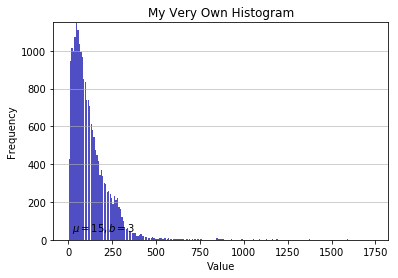

In [39]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=dist["Repi"], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [12]:
distTarget = df[["EpiD (km)","HypD (km)", "Joyner-Boore Dist. (km)", "RmsD (km)"]]

In [13]:
differences = pd.DataFrame(distTarget.values - dist.values,columns = ["EpiD (km)","HypD (km)", "Joyner-Boore Dist. (km)", "RmsD (km)"])

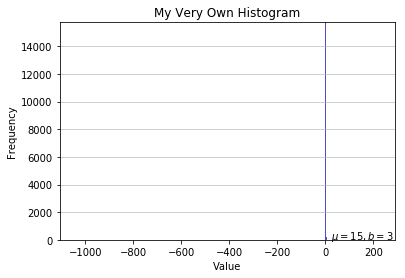

In [44]:
n, bins, patches = plt.hist(x=differences["EpiD (km)"], 
                            bins=1000, 
                            color='#0504aa',
                            alpha=0.7, 
                            rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.show()

In [48]:
df.iloc[np.where(differences["EpiD (km)"].abs()>25)[0], [9,10,11,12,18,19,20,26,27]]

,Strike (deg),Dip (deg),Hypocenter Latitude (deg),Hypocenter Longitude (deg),EpiD (km),HypD (km),Joyner-Boore Dist. (km),Station Latitude,Station Longitude
4288,-999.0,-999.0,40.857,15.711,-999.00,-999.00,-999.00,40.4580,15.6350
4560,230.0,50.0,30.986,103.364,1557.25,1557.28,1273.62,40.5000,116.0000
4561,230.0,50.0,30.986,103.364,1547.26,1547.29,1263.31,40.0000,116.3000
4562,230.0,50.0,30.986,103.364,1561.49,1561.52,1278.16,39.4000,117.1000
4584,230.0,50.0,30.986,103.364,1162.60,1162.64,878.72,38.1000,112.7000
4597,230.0,50.0,30.986,103.364,1400.74,1400.77,1292.76,25.8000,116.4000
4599,230.0,50.0,30.986,103.364,1582.21,1582.24,1307.11,36.8000,118.9000
4600,230.0,50.0,30.986,103.364,1315.68,1315.72,1036.17,36.8000,115.7000
4601,230.0,50.0,30.986,103.364,1628.86,1628.89,1353.78,36.9000,119.4000
4602,230.0,50.0,30.986,103.364,1553.77,1553.80,1279.82,36.5000,118.7000


In [66]:
dist.loc[4604]

Repi    1187.072708
Rhyp    1187.115165
Rjb     1040.528002
Rrup    1043.277882
Name: 4604, dtype: float64

In [14]:
XEvent= GeoDistance(EQLAT,EVENTLON,EQLAT,EQLON,"K")
YEvent= GeoDistance(EVENTLAT,EQLON,EQLAT,EQLON,"K")
repi = GeoDistance(EVENTLAT,EVENTLON,EQLAT,EQLON,"K")

In [15]:
repi[4560]

1552.4245325605891

In [16]:
repiQ = np.sqrt(XEvent**2+YEvent**2)
repiQQ = np.arccos(np.cos(XEvent)*np.cos(YEvent))

In [17]:
diffEpi = repi -repiQ*np.cos(np.radians(EQLON-EVENTLON))

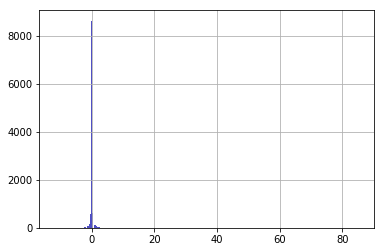

In [101]:
diffEpi.hist(bins=1000, 
                            color='#0504aa',
                            alpha=0.7, 
                            rwidth=0.85)

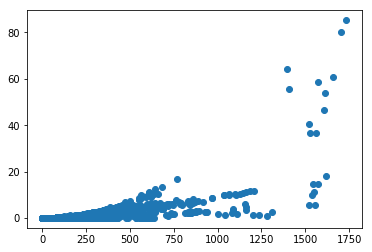

In [20]:
fig = plt.figure()
ax = plt.axes()

plt.plot(repi, diffEpi.abs() , "o")


In [22]:
diffEpi.mean()

0.0491307454615506